In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
import os
from scipy.interpolate import make_interp_spline
from scipy.ndimage import gaussian_filter1d

# DAGMM

In [2]:
class DAGMM(nn.Module):

    def __init__(self, enc_dims, estim_dims, types):
        super(DAGMM,self).__init__()

        self.encoder, self.decoder = self.construct_ae(enc_dims)
        self.estim_net = self.construct_estim_net(estim_dims, types)

        n_gmm = estim_dims[-1][1]
        latent_dim = enc_dims[-1][1] + 2 

        self.register_buffer("phi", torch.zeros(n_gmm))
        self.register_buffer("mu", torch.zeros(n_gmm, latent_dim))
        self.register_buffer("cov", torch.zeros(n_gmm, latent_dim, latent_dim))
        self.register_buffer("cov_inverse", torch.zeros(n_gmm, latent_dim, latent_dim))

    def construct_ae(self, dimensions):
        enc_layers = []
        n_dims = len(dimensions)
        for i in range(n_dims):
            enc_layers.append(nn.Linear(dimensions[i][0], dimensions[i][1]))
            if i < n_dims-1:
                enc_layers.append(nn.Tanh())

        rev_dims = dimensions[::-1]
        dec_layers = []
        for i in range(n_dims):
            dec_layers.append(nn.Linear(rev_dims[i][1], rev_dims[i][0]))
            if i < n_dims-1:
                dec_layers.append(nn.Tanh())

        return nn.Sequential(*enc_layers), nn.Sequential( *dec_layers)
    
    def construct_estim_net(self, dimensions, types):
        layers = []
        n_dims = len(dimensions)
        for i in range(n_dims):
            if types[i] == 'Linear':
                if i == 0:
                    layers.append(nn.Linear(dimensions[i][0] + 2, dimensions[i][1]))
                else:
                    layers.append(nn.Linear(dimensions[i][0], dimensions[i][1]))
                if i < n_dims-1:
                    layers.append(nn.Tanh())
                else:
                    layers.append(nn.Softmax(dim = -1))
            if types[i] == 'drop':
                layers.append(nn.Dropout(p=dimensions[i]))
        
        return nn.Sequential(*layers)

    def compute_gmm_params(self, z, gamma):
            N = gamma.size(0)
            sum_gamma = torch.sum(gamma, dim=0)

            # NOTA: Rimuoviamo .detach() e usiamo l'assegnazione diretta ai buffer
            self.phi = sum_gamma / N
            self.mu = torch.sum(gamma.unsqueeze(-1) * z.unsqueeze(1), dim=0) / sum_gamma.unsqueeze(1)

            z_mu = z.unsqueeze(1) - self.mu.unsqueeze(0)
            z_outer = z_mu.unsqueeze(-1) * z_mu.unsqueeze(-2)
            self.cov = torch.sum(gamma.unsqueeze(-1).unsqueeze(-1) * z_outer, dim=0) / sum_gamma.unsqueeze(-1).unsqueeze(-1)

    def compute_energy(self, z, flag=True):
            z_mu = z.unsqueeze(1) - self.mu.unsqueeze(0)

            eps = 1e-3
            eye = torch.eye(self.cov.size(-1)).to(self.cov.device)
            cov_reg = self.cov + (eye * eps)
            
            if flag:
                # Aggiorniamo il buffer della matrice inversa
                self.cov_inverse = torch.linalg.inv(cov_reg)

            log_det = 0.5 * torch.linalg.slogdet(2 * torch.pi * cov_reg)[1]

            # Utilizziamo self.cov_inverse (che ora è un buffer ricaricato)
            malan = -0.5 * torch.sum(torch.sum(z_mu.unsqueeze(-1) * self.cov_inverse.unsqueeze(0), dim=-2) * z_mu, dim=-1)
            exponent = torch.log(self.phi + eps).unsqueeze(0) + malan - log_det.unsqueeze(0)
            max_val = torch.max(exponent, dim=1, keepdim=True)[0]
            exp_term = torch.exp(exponent - max_val)

            energy = - (max_val.squeeze() + torch.log(torch.sum(exp_term, dim=1) + eps))

            diagonals = torch.diagonal(cov_reg, dim1=-2, dim2=-1)
            p_sigma = torch.sum(1.0 / (diagonals + eps))

            if flag:
                return torch.mean(energy), p_sigma
            else:
                return energy, p_sigma

    def con_loss(self, x, x_rec, z, gamma, lam_energy, lam_cov):
        rec_err = torch.mean((x-x_rec)**2)

        self.compute_gmm_params(z, gamma)

        energy, p_sigma = self.compute_energy(z)
        
        total_loss = rec_err + lam_energy * energy + lam_cov * p_sigma

        return {
            "total": total_loss,
            "rec": rec_err,
            "energy": energy,
            "cov": p_sigma
        }

    def get_estimation_input(self, x, x_rec, z_c):
        # Compute the inpute vector to the estimation net
        # Euclidean dist
        euclidean_dist = torch.norm(x - x_rec, p=2, dim=1, keepdim=True) / torch.norm(x, p=2, dim=1, keepdim=True)
        
        # Cosine Similarity
        cosine_sim = nn.functional.cosine_similarity(x, x_rec, dim=1).unsqueeze(1)
        
        z_combined = torch.cat([z_c, euclidean_dist, cosine_sim], dim=1)
        return z_combined

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            z = self.encoder(x)
            x_rec = self.decoder(z)
            est_in = self.get_estimation_input(x, x_rec, z)

        return self.compute_energy(est_in, False)

    def forward(self, X):
        z = self.encoder(X)
        x_rec = self.decoder(z)

        est_in = self.get_estimation_input(X, x_rec, z)
        gamma = self.estim_net(est_in)

        return x_rec, est_in, gamma

In [3]:
df = pd.read_csv('Data/kddcup.data/kddcup.data', header=None)

In [4]:
def preprocess_kdd(df):
    # Mantaining the colums only for the after cjecdk
    labels = df.iloc[:, -1]
    data = df.iloc[:, :-1]
    
    for col in data.columns:
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    return torch.tensor(data_scaled).float(), labels

In [14]:
def train_dagmm(model, data_tensor, epochs=50, batch_size=1024, lr=1e-3, lam_energy=0.3, lam_cov=0.05):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"training on {device}")
    model.to(device)
    
    dataset = TensorDataset(data_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'total': [], 'rec': [], 'energy': [], 'cov': []}
    
    model.train()
    for epoch in range(epochs):
        epoch_total, epoch_rec, epoch_energy, epoch_cov = 0, 0, 0, 0
        
        for batch in dataloader:
            x = batch[0].to(device)
            
            x_rec, z, gamma = model(x)

            loss_dict = model.con_loss(x, x_rec, z, gamma, lam_energy, lam_cov)
            
            optimizer.zero_grad()
            loss_dict["total"].backward() 

            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            
            optimizer.step()

            epoch_total += loss_dict["total"].item()
            epoch_rec += loss_dict["rec"].item()
            epoch_energy += loss_dict["energy"].item()
            epoch_cov += loss_dict["cov"].item()
            
        num_batches = len(dataloader)
        history['total'].append(epoch_total / num_batches)
        history['rec'].append(epoch_rec / num_batches)
        history['energy'].append(epoch_energy / num_batches)
        history['cov'].append(epoch_cov / num_batches)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Total Loss: {history['total'][-1]:.4f}")

    print("Training Completed!")
    return history

In [15]:
def split_dataset(X, y):
    normal_mask = (y == 'normal.') | (y == 'normal')
    
    X_normal = X[normal_mask]
    y_normal = y[normal_mask]
    X_anomaly = X[~normal_mask]
    y_anomaly = y[~normal_mask]

    X_train_np, X_rest_np, _, y_rest = train_test_split(
        X_normal.numpy(), y_normal.values, test_size=0.2, random_state=42
    )

    X_val_test_np, y_val_test = np.concatenate([X_rest_np, X_anomaly.numpy()]), np.concatenate([y_rest, y_anomaly.values])
    X_val_np, X_test_np, y_val, y_test = train_test_split(
        X_val_test_np, y_val_test, test_size=0.5, random_state=42
    )
    
    return (torch.tensor(X_train_np).float(), torch.tensor(X_val_np).float(), torch.tensor(X_test_np).float(), y_val, y_test)

In [13]:
def find_optimal_threshold(model, X_val, y_val):
    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        energy, _ = model.predict(X_val.to(device))
    
    energy = energy.cpu().numpy()
    
    y_true = ((y_val != 'normal.') & (y_val != 'normal')).astype(int)
    
    precision, recall, thresholds = precision_recall_curve(y_true, energy)
    pr_auc = average_precision_score(y_true, energy)  

    f1_scores = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
    
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    
    print(f"--- Risultats of Validation ---")
    print(f"PR-AUC (Average Precision): {pr_auc:.4f}")
    print(f"Best F1-Score: {f1_scores[best_idx]:.4f}")
    print(f"Optimal th: {best_threshold:.4f}")
    
    return best_threshold

In [19]:
def evaluate_performance(model, X_test, y_test, threshold):
    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        energy, _ = model.predict(X_test.to(device))
    
    energy = energy.cpu().numpy()
    y_pred = (energy > threshold).astype(int)
    y_true = ((y_test != 'normal.') & (y_test != 'normal')).astype(int)
    
    print("\n--- Performances on Test Set ---")
    print(classification_report(y_true, y_pred, target_names=['Anomaly', 'Normal']))
    
    cm_norm = confusion_matrix(y_true, y_pred, normalize='true') 
    
    fig, ax = plt.subplots(figsize=(8, 6))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['Anomaly', 'Normal'])
    
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='.2%')
    
    ax.set_title(f'Confusion Matrix - Proportions\n(Threshold: {threshold:.4f})')
    
    if disp.im_.colorbar: 
        disp.im_.colorbar.remove()
    ax.grid(False)

    plt.tight_layout()
    plt.show()

In [9]:
def plot_loss_history(history):
    fig, axes = plt.subplots(4, 1, figsize=(10, 15), sharex=True)
    
    epochs = range(len(history['total']))
    
    axes[0].plot(epochs, history['total'], color='tab:blue', linewidth=2)
    axes[0].set_title('Total Loss')
    axes[0].set_ylabel('Value')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(epochs, history['rec'], color='tab:orange', linestyle='--')
    axes[1].set_title('Reconstruction Error (AE Performance)')
    axes[1].set_ylabel('Value')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(epochs, history['energy'], color='tab:green', linestyle=':')
    axes[2].set_title('Energy Term')
    axes[2].set_ylabel('Value')
    axes[2].grid(True, alpha=0.3)
    
    axes[3].plot(epochs, history['cov'], color='tab:red', alpha=0.6)
    axes[3].set_title('Covariance Penalty')
    axes[3].set_ylabel('Value')
    axes[3].set_xlabel('Epochs')
    axes[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [10]:
def train_and_update_history(model, data_tensor, filename='history_loss.pkl', epochs=50, **kwargs):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            full_history = pickle.load(f)
        print(f"History precedente caricata ({len(full_history['total'])} epoche).")
    else:
        full_history = {'total': [], 'rec': [], 'energy': [], 'cov': []}
        print("Nessuna history trovata. Ne creo una nuova.")

    new_history = train_dagmm(model, data_tensor, epochs=epochs, **kwargs)

    for key in full_history.keys():
        full_history[key].extend(new_history[key])

    with open(filename, 'wb') as f:
        pickle.dump(full_history, f)
    
    print(f"Training completato. History totale ora contiene {len(full_history['total'])} epoche.")
    return full_history

In [20]:
X_all, y_all = preprocess_kdd(df)
X_train, X_val, X_test, y_val, y_test = split_dataset(X_all, y_all)

In [21]:
input_dim = X_train.shape[1]
model = DAGMM(enc_dims=[[input_dim, 60], [60, 30], [30, 10], [10, 1]], 
              estim_dims=[[1, 10], [10, 4]], 
              types=['Linear', 'Linear'])

In [34]:
loss = train_dagmm(model, X_train, epochs=50, batch_size=1024)

training on cuda
Epoch [10/50], Total Loss: 1.7399
Epoch [20/50], Total Loss: 1.6531
Epoch [30/50], Total Loss: 1.9274
Epoch [40/50], Total Loss: 1.9081
Epoch [50/50], Total Loss: 1.7997
Training Completed!


In [38]:
history = train_and_update_history(model, X_train, filename='history_loss.pkl', epochs=50, batch_size=1024, lr=1e-4)

History precedente caricata (50 epoche).
training on cuda
Epoch [10/50], Total Loss: 1.4939
Epoch [20/50], Total Loss: 1.6265
Epoch [30/50], Total Loss: 1.6225
Epoch [40/50], Total Loss: 1.6142
Epoch [50/50], Total Loss: 1.7689
Training Completed!
Training completato. History totale ora contiene 100 epoche.


In [37]:
with open('history_loss.pkl', 'wb') as f:
    pickle.dump(loss, f)

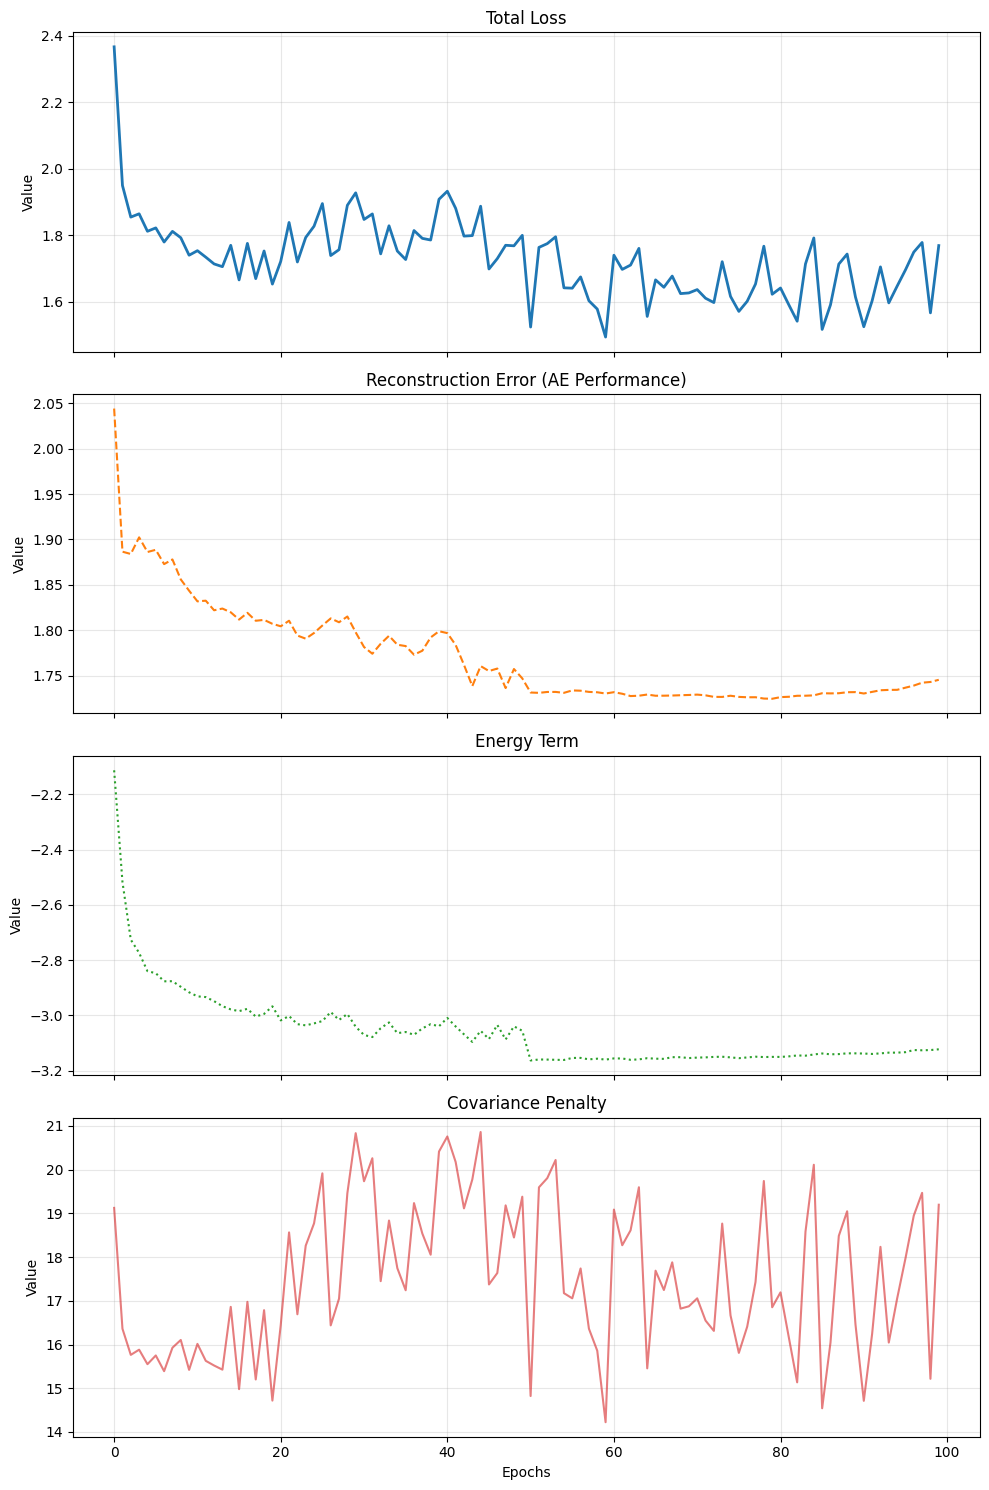

In [39]:
plot_loss_history(history)

In [96]:
torch.save(model.state_dict(), "DAGMM_best.pth")

In [22]:
model.load_state_dict(torch.load("DAGMM_best_complete.pth"))
model.eval()

DAGMM(
  (encoder): Sequential(
    (0): Linear(in_features=41, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=60, bias=True)
    (5): Tanh()
    (6): Linear(in_features=60, out_features=41, bias=True)
  )
  (estim_net): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=4, bias=True)
    (3): Softmax(dim=-1)
  )
)

In [23]:
optimal_thresh = find_optimal_threshold(model, X_val, y_val)

--- Risultats of Validation ---
PR-AUC (Average Precision): 1.0000
Best F1-Score: 0.9983
Optimal th: -4.7714



--- Performances on Test Set ---
              precision    recall  f1-score   support

     Anomaly       0.98      0.95      0.96     97189
      Normal       1.00      1.00      1.00   1962915

    accuracy                           1.00   2060104
   macro avg       0.99      0.98      0.98   2060104
weighted avg       1.00      1.00      1.00   2060104



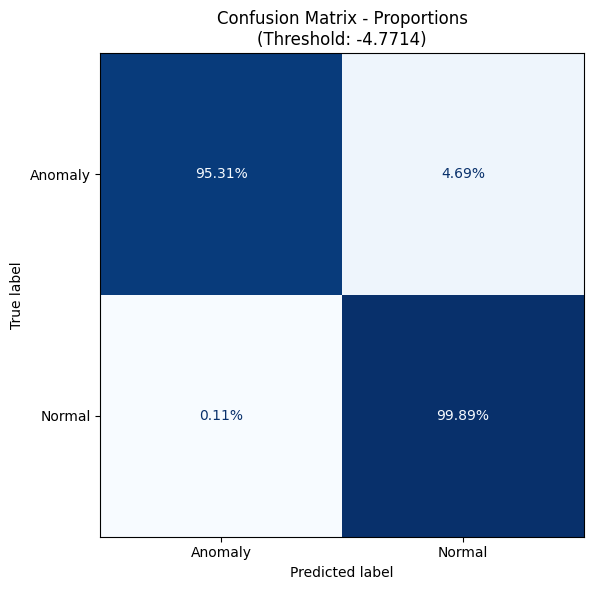

In [24]:
evaluate_performance(model, X_test, y_test, optimal_thresh)

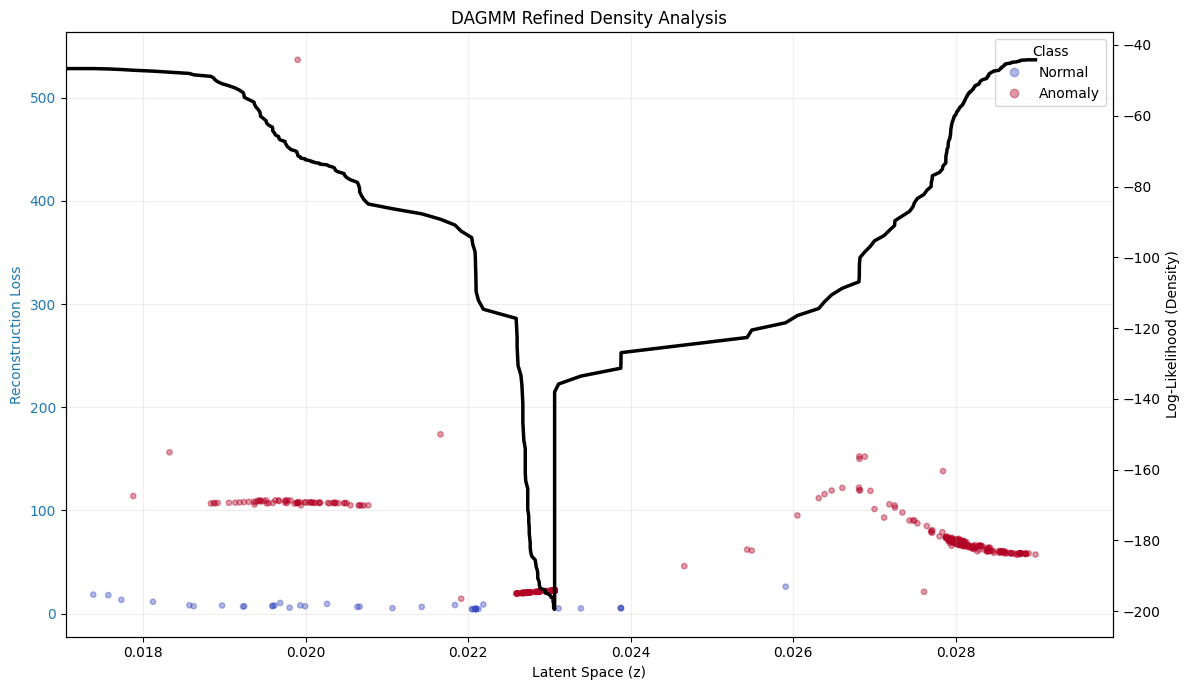

In [25]:
def plot_refined_dagmm_analysis(model, X_test, y_test):
    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        X_tensor = X_test.to(device)
        # CORREZIONE: L'ordine di ritorno del forward nel tuo modello è (x_rec, est_in, gamma)
        x_rec, z_combined, gamma = model(X_tensor) 
        
        # Calcolo errore di ricostruzione per ogni punto
        rec_loss = torch.sum((X_tensor - x_rec)**2, dim=1).cpu().numpy()
        
        # Estraiamo la coordinata latente (z) effettiva, solitamente la prima colonna di est_in
        # Nel tuo codice z_combined contiene [z_c, euclidean_dist, cosine_sim]
        z_latent = z_combined[:, 0].cpu().numpy() 
        
        # Calcolo Log-Likelihood reale punto per punto usando l'energia
        energy, _ = model.compute_energy(z_combined, flag=False)
        log_likelihood = -energy.cpu().numpy()

    # Prepariamo le etichette per i colori
    y_true = ((y_test != 'normal.') & (y_test != 'normal')).astype(int)
    
    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # 1. Scatter dei campioni (trasparenza media)
    scatter = ax1.scatter(z_latent, rec_loss, c=y_true, cmap='coolwarm', 
                          alpha=0.4, s=15, label='Samples')
    
    # Stringiamo l'asse X sui dati reali (percentili 0.5 e 99.5 per rimuovere outlier visivi)
    x_min, x_max = np.percentile(z_latent, [0.5, 99.5])
    padding = (x_max - x_min) * 0.1
    ax1.set_xlim(x_min - padding, x_max + padding)
    
    ax1.set_xlabel('Latent Space (z)')
    ax1.set_ylabel('Reconstruction Loss', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, alpha=0.2)

    # 2. Curva di Densità (Log-Likelihood) interpolata
    ax2 = ax1.twinx()
    
    # Ordiniamo i dati rispetto a z per tracciare la curva
    sort_idx = np.argsort(z_latent)
    z_sorted = z_latent[sort_idx]
    ll_sorted = log_likelihood[sort_idx]
    
    # Smoothing gaussiano: sigma=15 o 20 rende la curva molto fluida
    ll_smooth = gaussian_filter1d(ll_sorted, sigma=20)
    
    ax2.plot(z_sorted, ll_smooth, color='black', linewidth=2.5, label='Density Profile')
    ax2.set_ylabel('Log-Likelihood (Density)', color='black')
    
    plt.title('DAGMM Refined Density Analysis')
    
    # Legenda
    handles, labels = scatter.legend_elements()
    ax1.legend(handles, ['Normal', 'Anomaly'], loc="upper right", title="Class")
    
    fig.tight_layout()
    plt.show()

# Esempio di chiamata
plot_refined_dagmm_analysis(model, X_test[:1000], y_test[:1000])